### E3. 프로젝트: 고양이 수염 스티커 만들기

### 학습목표: 
    1. 카메라앱 만들기를 통해 동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근 의 기술을 다룹니다.
    2. 간단한 스티커부터 시작해서 각도 변화가 가능하고 거리 변화에 강건한 스티커 까지 만들 수 있습니다.

$ mkdir -p ~/aiffel/camera_sticker/models
$ mkdir -p ~/aiffel/camera_sticker/images

작업 폴더를 만들고, 내 사진과 고양이 수염 이미지를 담아둡니다.

In [1]:
import os #운영체제 관련 함수 호출 (디렉토리 경로에서 이미지를 불러오기 위해)
import cv2 # 컴퓨터 비젼 라이브러리 버젼2
import matplotlib.pyplot as plt #opencv 와 노트북에 이미지를 출력하기 위한 matplotlib를 읽어옵니다.
import numpy as np
import dlib # face detecting 라이브러리

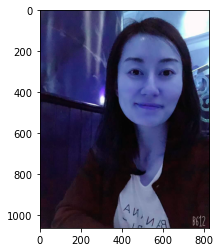

In [102]:
#준비한 내 사진 이미지를 읽어옵니다.

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/me.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
#img_bgr = cv2.resize(img_bgr, (828,1062))    # 해상도 별도 조정없이 원본을 그대로 씀. 조정해서 해 봤으나, 좌표 설정이 더 어려워서, 큰 싸이즈의 사진으로 함.
img_show = img_bgr.copy() #- 출력 테스트 용 이미지 
plt.imshow(img_bgr)
plt.show()

opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 아래와 같은 색깔 보정처리

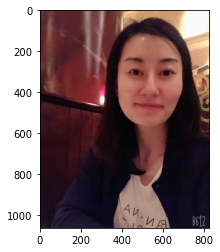

In [103]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)#opencv 의 bgr 이미지를 rgb로 변환
plt.imshow(img_rgb)
plt.show()

In [104]:
print([a for a in dir(dlib) if 'get_' in a]) #  어떤 함수가 제공되나 탐색
#https://hayunjong83.tistory.com/38
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
#img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #위에서 해서, 다시 변환 할 필요 없음.

dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)# 찾은 얼굴영역 좌표

['get_face_chip', 'get_face_chip_details', 'get_face_chips', 'get_frontal_face_detector', 'get_histogram', 'get_rect']
rectangles[[(332, 204) (718, 590)]]


[(332, 204) (718, 590)]


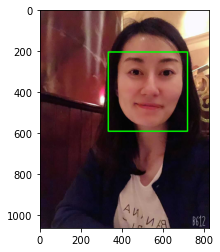

In [105]:

for dlib_rect in dlib_rects:
    print(dlib_rect)
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 5, lineType=cv2.LINE_8) 
# 왜 굳이 안티얼라이징? 8-connected 는 무엇 ? lineType을 바꾸니 오류가 남. 

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

###  얼굴 랜드마크 face landmark

1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측
2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

In [53]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [106]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0][0]))# 68개의 랜드마크
print(list_landmarks[0][0][0])
print(list_landmarks[0][0][1])

2
376
305


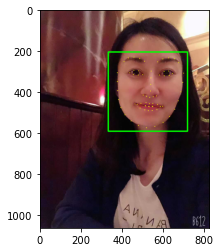

In [107]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [108]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0] #- 스티커 위치의 초기 기준점
    y = landmark[30][1] 
    
    w = int((landmark[30][0]  - landmark[36][0]) * 2.1)  #: 왼쪽 눈끝
    h = int((landmark[48][1]  - landmark[2][1])  * 2.1)   # 왼쪽 입끝을 기준으로 고양이 수염 이미지의 크기를 맞춤
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    

(538, 394)
(x,y) : (538,394)
(w,h) : (212,136)


In [109]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat2.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h//1))
print (img_sticker.shape)

(136, 212, 3)


In [115]:
#마의 구간 
refined_x = x - w // 2  # left 위에서 다 계산 함.
refined_y = (int(y - h*0.5)) #수염이 붙을 곳의 높이 조절
print ('(x,y) : (%d,%d)'%(refined_x, refined_y)) # 음수값이 아니므로, 이미지 crop 안 함.

(x,y) : (432,326)


In [116]:
x_shape = img_sticker.shape[0]
y_shape = img_sticker.shape[1]
print ('(x,y) : (%d,%d)'%(x_shape,y_shape))
print ('(x,y) : (%d,%d)'%(refined_x,refined_x))

(x,y) : (136,212)
(x,y) : (432,432)


In [112]:
print(img_show.shape)
sticker_area = img_show[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape]
print(sticker_area.shape)


img_show[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

(1062, 828, 3)
(136, 212, 3)


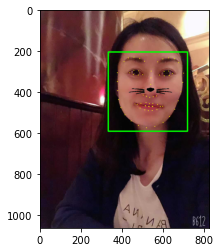

In [113]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

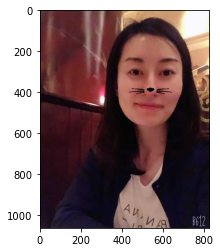

In [117]:
sticker_area = img_bgr[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape]

img_bgr[refined_y:refined_y+x_shape, refined_x:refined_x+y_shape] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 총평 및 문제점 찾아보기

1. 사진 크기를 처음에 노드에 나온 것처럼, 작은 싸이즈로 했을 때, 비율 맞추기가 어려웠다. 사진 크기를 원본 크기로 사용하니, 좌표 맞추기가 생각한 것과 같이 나왔다. 얼굴 이미지가 작은 사진은 랜드마크가 정확하게 설정되지 않기 때문에 위치가 생각처럼 맞춰지지 않은것 같다. 

2. 얼굴 각도에 따른 테스트를 못해봤지만, 랜드마크의 정확도가 떨어져서 스티커의 위치를 맞추지 못할 것 같다고 생각한다.  

3. 노드 시작전에 말로 또는 영상으로 설명(강의)을 듣고 혼자 해보는 시간이 있었으면 좋겠다. 